<h1><center>Bixi Bicycle Trip Explorer</center></h1>

In this Python worflow we explore the Montreal Bixi biking data set for the year 2017 https://www.kaggle.com/aubertsigouin/biximtl/data.<br> 
<!--We have additionally enriched this data set with the biking distance/duration available via Google map API as gmdata2017.-->

Our objective is to predict the "trip duration", given the distance between two stations using linear regression.

***

Once we import AIDA components, we are good to go !

In [1]:
from aida.aida import *;

Let us start by establishing a connection to the database and get a connection object. This is syntactically very similar to any JDBC/ODBC based applications.

In [2]:
host='cerberus'; dbname='demo'; user='demo'; passwd='demo'; jobName='bixiExplorer-RWS'; port=55660;
dw = AIDA.connect(host, dbname, user, passwd, jobName, port);

Let us see what data sets we have in the database. This will give us a list of tables.

In [3]:
tables(dw);

       tablename
0   tripdata2017
1   stations2017
2     gmdata2017
3         region
4         nation
5           part
6       supplier
7       partsupp
8       customer
9         orders
10      lineitem


Let us take a peek into trip data.<br>

In [4]:
head(dw.tripdata2017);

   id                  starttm  stscode                    endtm  endscode  \
0   0  2017-04-15 00:00:00.000     7060  2017-04-15 00:31:00.000      7060   
1   1  2017-04-15 00:01:00.000     6173  2017-04-15 00:10:00.000      6173   
2   2  2017-04-15 00:01:00.000     6203  2017-04-15 00:04:00.000      6204   
3   3  2017-04-15 00:01:00.000     6104  2017-04-15 00:06:00.000      6114   
4   4  2017-04-15 00:01:00.000     6174  2017-04-15 00:11:00.000      6174   

   duration  ismember  
0      1841         1  
1       553         1  
2       195         1  
3       285         1  
4       569         1  


We can also see the distribution of values and statistical characteristics of this data set.

In [5]:
describe(dw.tripdata2017);

                            id                 starttm  \
count   [          4018721.00]  [          4018721.00]   
unique  [          4018721.00]  [           227660.00]   
nulls   [                0.00]  [                0.00]   
max     [          4018721.00]  [ 2017-09-30 23:59:00]   
min     [                0.00]  [ 2017-04-15 00:00:00]   
avg     [          2009360.21]  [                    ]   
median  [          2009360.00]  [                    ]   
25%     [          1004680.00]  [                    ]   
50%     [          2009360.00]  [                    ]   
75%     [          3014040.00]  [                    ]   
stddev  [          1160105.11]  [                    ]   

                       stscode                   endtm  \
count   [          4018721.00]  [          4018721.00]   
unique  [              546.00]  [           227784.00]   
nulls   [                0.00]  [                0.00]   
max     [            10002.00]  [ 2017-10-01 00:55:00]   
min     [    

AIDA sends only the minimal data that the users need to look into which is very bandwidth efficient.

Looking at the duration attribute, it looks like there are trips ranging from 2 hours to just a minute.
<!--It will be interesting to see their distribution.-->

***

Next we will analyze the number of trips between different stations to see which station pairs are popular. <br>
This can be done by doing an aggregation using AIDA's ORM syntax. Equivalent of SQL GROUP BY clause.<br>
These operations are internally executed using the database engine.

In [6]:
tripStations = dw.tripdata2017.aggregate(('stscode','endscode',{COUNT('*'):'numtrips'}), ('stscode','endscode'));
describe(tripStations);

                       stscode                endscode                numtrips
count   [           189413.00]  [           189413.00]  [           189413.00]
unique  [              546.00]  [              546.00]  [              749.00]
nulls   [                0.00]  [                0.00]  [                0.00]
max     [            10002.00]  [            10002.00]  [             2997.00]
min     [             5002.00]  [             5002.00]  [                1.00]
avg     [             6378.97]  [             6382.61]  [               21.22]
median  [             6247.00]  [             6250.00]  [                6.00]
25%     [             6132.00]  [             6129.00]  [                2.00]
50%     [             6247.00]  [             6250.00]  [                6.00]
75%     [             6436.00]  [             6504.00]  [               20.00]
stddev  [              365.78]  [              377.62]  [               52.54]


There are close two 2 million station pairings. However, it looks like most of them have very few actual trips between them. 75% of the station pairs have less than 20 trips. Let us remove those to focus solely on station pairs that has sufficient amount of trip data.<br> We will restrict ourselves to those with at the least 100 trips.

In [7]:
freqTripStations = tripStations.filter(Q('numtrips',C(100), CMP.GTE));
describe(freqTripStations);

                       stscode                endscode                numtrips
count   [             7373.00]  [             7373.00]  [             7373.00]
unique  [              516.00]  [              522.00]  [              650.00]
nulls   [                0.00]  [                0.00]  [                0.00]
max     [            10002.00]  [            10002.00]  [             2997.00]
min     [             5004.00]  [             5002.00]  [              100.00]
avg     [             6291.42]  [             6274.83]  [              201.81]
median  [             6186.00]  [             6173.00]  [              149.00]
25%     [             6097.00]  [             6073.00]  [              118.00]
50%     [             6186.00]  [             6173.00]  [              149.00]
75%     [             6338.00]  [             6339.00]  [              213.00]
stddev  [              362.19]  [              357.25]  [              168.50]


We should also remove any "trips" where the start and end station are the same as many of these are noise in the data.

In [8]:
freqTripStations = freqTripStations.filter(Q('stscode', 'endscode', CMP.NE));
describe(freqTripStations);

                       stscode                endscode                numtrips
count   [             7061.00]  [             7061.00]  [             7061.00]
unique  [              510.00]  [              517.00]  [              634.00]
nulls   [                0.00]  [                0.00]  [                0.00]
max     [            10002.00]  [            10002.00]  [             2200.00]
min     [             5004.00]  [             5002.00]  [              100.00]
avg     [             6288.06]  [             6270.73]  [              200.58]
median  [             6184.00]  [             6169.00]  [              149.00]
25%     [             6097.00]  [             6070.00]  [              118.00]
50%     [             6184.00]  [             6169.00]  [              149.00]
75%     [             6323.00]  [             6322.00]  [              212.00]
stddev  [              360.76]  [              355.39]  [              161.89]


We need the distance travelled, however trip data did not have it. Let us take a look at what we have in the stations data set.

In [9]:
head(dw.stations2017);

   scode                      sname  slatitude  slongitude  sispublic
0   7060  "de l'Église / de Verdun"  45.463001  -73.571569          1
1   6173         "Berri / Cherrier"  45.519088  -73.569509          1
2   6203   "Hutchison / Sherbrooke"  45.507810  -73.572080          1
3   6204        "Milton / Durocher"  45.508144  -73.574772          1
4   6104    "Wolfe / René-Lévesque"  45.516818  -73.554188          1


This data set has the latitude / longitude coordiante information of each station.<br>
We can compute an approximate distance between two stations using some geodesic package.<br>
But first let us bring in the coordinates into our working data set for both the start and end stations. We can do this through relational joins.

In [10]:
freqTripStationsCord = freqTripStations \
    .join(dw.stations2017, ('stscode',), ('scode',), COL.ALL, ({'slatitude':'stlat'}, {'slongitude':'stlong'})) \
    .join(dw.stations2017, ('endscode',), ('scode',), COL.ALL, ({'slatitude':'enlat'}, {'slongitude':'enlong'}));

In [11]:
head(freqTripStationsCord);

   stscode  endscode  numtrips      stlat     stlong      enlat     enlong
0     6203      6204       101  45.507810 -73.572080  45.508144 -73.574772
1     6104      6114       308  45.516818 -73.554188  45.523530 -73.551990
2     6281      6158       113  45.527727 -73.586284  45.530730 -73.581530
3     6018      6119       251  45.518890 -73.563530  45.526970 -73.558021
4     6019      6145       126  45.517910 -73.567143  45.524566 -73.572079


We can visualize these stations in a map to see where these trips are originating from.<br>
Let us also get the station names to make the map more informative.

In [12]:
freqTripStationsNames = freqTripStationsCord \
    .join(dw.stations2017, ('stscode',), ('scode',), ('stscode', 'stlat', 'stlong', 'numtrips'), ('sname',));
head(freqTripStationsNames);

   stscode      stlat     stlong  numtrips                     sname
0     6203  45.507810 -73.572080       101  "Hutchison / Sherbrooke"
1     6104  45.516818 -73.554188       308   "Wolfe / René-Lévesque"
2     6281  45.527727 -73.586284       113     "Resther / St-Joseph"
3     6018  45.518890 -73.563530       251      "St-André / Ontario"
4     6019  45.517910 -73.567143       126      "Berri / Sherbrooke"


Let us plot it in a map.

In [13]:
def mapStations(dw, tblrData):
    import plotly.graph_objs as go;
    from aidacommon.aidaConfig import AConfig;
    recs = tblrData.cdata;
    return {'data': [ {'lat':recs['stlat'], 'lon':recs['stlong'], 'mode':'markers'
                       ,'marker':{'size':recs['numtrips']/100+4, 'color':recs['numtrips']
                                  ,'colorscale':'Viridis', 'showscale':True}
                       ,'text':recs['sname'], 'type': 'scattermapbox'} ],
            'layout' : {'mapbox':{'accesstoken':AConfig.MAPBOXTOKEN
                                  ,'bearing':315
                                  ,'center':{'lat':(max(recs['stlat'])+min(recs['stlat']))/2
                                             ,'lon':(max(recs['stlong'])+min(recs['stlong']))/2}
                                  ,'zoom':12 },
                       'title':'Bixi stations of interest'}, 'width':500, 'height':500}

In [14]:
plth = dw._Plot(mapStations, freqTripStationsNames);
show(plth);

In [15]:
print(plth);

http://127.0.1.1:55670/bixiExplorer-RWS/f722b547-edfd-475c-8e8b-3e2ee2e25ad0


Now we need to find the distance between each of these station pairs. We will do some feature engineering and use Vincenty's formula to compute that using a user transformation. There is a third party library, geopy to help us do the job.

In [16]:
def computeDist(tblrData):
    import geopy.distance;     #We will use this module to compute distance.
    import copy, numpy as np;
    #We are going to keep all the columns of the original source tabularData object.
    data = copy.copy(tblrData.rows); #This only makes a copy of the metadata, but retains original column data
    vdistm = data['vdistm'] = np.empty(tblrData.numRows, dtype=int); #add a new empty column to hold distance.
    stlat = data['stlat']; stlong = data['stlong']; enlat = data['enlat']; enlong = data['enlong'];
    for i in range(0, tblrData.numRows): #populate the distance metric using longitude/latitude of coordinates.
        vdistm[i] = int(geopy.distance.distance((stlat[i],stlong[i]), (enlat[i],enlong[i])).meters);
    return data;

In [17]:
freqTripStationsDist = freqTripStationsCord._U(computeDist); #Execute the user transform
head(freqTripStationsDist);                                 #Take a peek at a sample data.

   stscode  endscode  numtrips      stlat     stlong      enlat     enlong  \
0     6203      6204       101  45.507810 -73.572080  45.508144 -73.574772   
1     6104      6114       308  45.516818 -73.554188  45.523530 -73.551990   
2     6281      6158       113  45.527727 -73.586284  45.530730 -73.581530   
3     6018      6119       251  45.518890 -73.563530  45.526970 -73.558021   
4     6019      6145       126  45.517910 -73.567143  45.524566 -73.572079   

   vdistm  
0     213  
1     765  
2     499  
3     995  
4     834  


Let us now extract the data from the trip data set that contains these selected station pairs.

In [18]:
tripData = dw.tripdata2017.join(freqTripStationsDist, ('stscode','endscode'), ('stscode', 'endscode')
                                             , ('id', 'duration'), ('vdistm',));

In [19]:
head(tripData);
describe(tripData);

   id  duration  vdistm
0   2       195     213
1   3       285     765
2  16       280     499
3  19       209     995
4  20       391     834
                            id                duration                  vdistm
count   [          1416269.00]  [          1416269.00]  [          1416269.00]
unique  [          1416269.00]  [             6222.00]  [             2183.00]
nulls   [                0.00]  [                0.00]  [                0.00]
max     [          4018720.00]  [             7199.00]  [             6573.00]
min     [                2.00]  [               61.00]  [               71.00]
avg     [          2000105.84]  [              568.38]  [             1199.04]
median  [          2003465.00]  [              414.00]  [              988.00]
25%     [           988664.00]  [              265.00]  [              656.00]
50%     [          2003465.00]  [              414.00]  [              988.00]
75%     [          3007886.00]  [              685.00]  [         

It looks like there are still trips in the 1 minute - 2 hour range. We should take a look at the distribution of the trip duration values.<br>
Further, if these are outliers, we would like to observe the effect of these outliers on our analysis. We will setup an interactive widget that helps us to select the range of data that we are interested int. 

In [20]:
dw.tripData = tripData; #First store reference to our master dataset in the connection object.

def chooseTrips(dw,app):
    from aida.aida import Q, CMP, C, COUNT;
    import dash_core_components as dcc;
    import dash_html_components as html;
    from dash.dependencies import Input, Output, State;

    dw.selTrips = dw.tripData; recs = dw.selTrips.cdata; #We start with the entire data set.
    minDur = 0; maxDur = recs['duration'].max();
    
    layout = html.Div([ # ==> This is the layout of our interactive widget.
       html.Div(id=dw.genDivId('tripDurGraph')) # ==> We plot the graph here. 
       ,dcc.RangeSlider(id=dw.genDivId('tripDurRange'), min=minDur, max=maxDur # ==> And a slider here.
                      ,value=[minDur, maxDur], step=1
                      ,marks={i: '{} min'.format(int(i/60)) for i in range(minDur, maxDur, 600)})
       ]);

    def recompute(start, end): #Rebuild the trip data based on the range chosen.
        dw.selTrips =  dw.tripData.filter(Q('duration', C(start), CMP.GTE), Q('duration', C(end), CMP.LTE));
        tripDur    =  dw.selTrips.aggregate(('duration',{COUNT('*'):'numtrips'}), ('duration',));
        recs = tripDur.cdata;
        return dcc.Graph(figure={ 'data': [ { 'x':recs['duration'], 'y': recs['numtrips'], 'type': 'bar' }, ]
                                   ,'layout': {'title':'Trip duration historgram'
                                               ,'xaxis':{'title':'duration (seconds)'}
                                               ,'yaxis':{'title':'number of trips'} } });

    # This function will be called everytime the slider is adjusted.
    @app.callback( Output(dw.getDivId('tripDurGraph'), 'children')
                  ,[Input(dw.getDivId('tripDurRange'), 'value')])
    def updateGraph(durRange):
        return recompute(durRange[0], durRange[1]);

    return layout;

In [21]:
pltp = dw._Page(chooseTrips);
show(pltp);

In [22]:
head(dw.selTrips);

   id  duration  vdistm
0   2       195     213
1   3       285     765
2  16       280     499
3  19       209     995
4  20       391     834


We can see that everytime we change the slider, the selected trips data set is getting automatically updated.

We will now take a look at the distribution of duration vs distance of this data set as a scatter plot, using matplotlib.

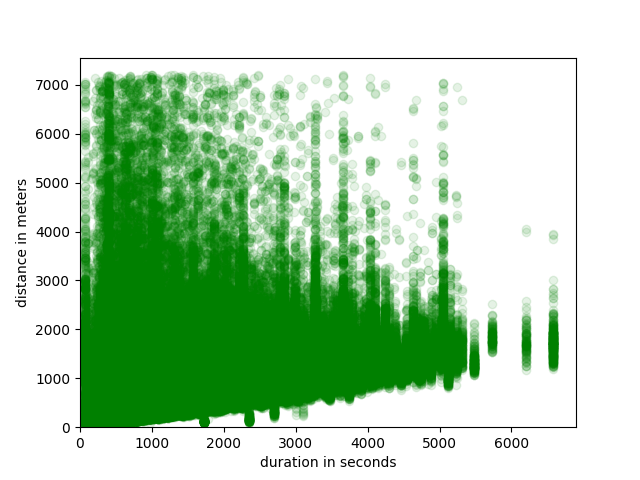

In [23]:
def scatterDistDuration(dw):
    data = dw.selTrips.cdata;
    fig = plt.figure();
    ax = fig.add_subplot(111);
    ax.scatter(data['vdistm'], data['duration'], c='g', alpha=0.1);
    ax.set_xlim((0,None));ax.set_ylim((0,None));
    ax.set_xlabel('duration in seconds');ax.set_ylabel('distance in meters');
    return fig;

img=dw._Plot(scatterDistDuration);
show(img);

Time to start preparing the data set for linear regression. Since duration and distance has large values, it will be a good idea to apply feature scaling on them. 

In [24]:
maxduration = dw.selTrips.max('duration');
maxdist = dw.selTrips.max('vdistm');
print('maxduration = {}, maxdist = {}'.format(maxduration, maxdist));

maxduration = 7199, maxdist = 6573


In [25]:
scaledTripData = dw.selTrips.project(('id', 1.0*F('duration')/maxduration, 1.0*F('vdistm')/maxdist, ));

In [26]:
head(scaledTripData);

   id  duration    vdistm
0   2  0.027087  0.032405
1   3  0.039589  0.116385
2  16  0.038894  0.075917
3  19  0.029032  0.151377
4  20  0.054313  0.126883


Now we need to split it into test and training data.<br>
We will keep some data apart for testing. A rule of thumb is 30%. The neat trick below sets apart 33%. Close enough.

In [27]:
testData = scaledTripData[::3];
head(testData);

   id  duration    vdistm
0   2  0.027087  0.032405
1  19  0.029032  0.151377
2  28  0.070288  0.157767
3  36  0.030560  0.085501
4  47  0.034727  0.128252


Now we take the rest of the data for training.

In [28]:
trainData = scaledTripData.filter(Q('id', testData.project(('id',)), CMP.NOTIN));
head(trainData);

   id  duration    vdistm
0   3  0.039589  0.116385
1  16  0.038894  0.075917
2  20  0.054313  0.126883
3  21  0.032782  0.049140
4  33  0.086262  0.263654


Our linear regression equation is of the form.<br>
$dur = a + b \times dist$ <br>
we will re-organize the training data set to fit this format and also setup our initial parameters for $a$ and $b$.

In [29]:
dw.trainDataSet = dw._ones((trainData.numRows, 1), ("x0",)).hstack(trainData[:,['vdistm']]);
head(dw.trainDataSet);
dw.trainDataSetDuration = trainData[:,['duration']];
head(dw.trainDataSetDuration);
dw.params = dw._ones((1,2), ("a","b"));

    x0    vdistm
0  1.0  0.116385
1  1.0  0.075917
2  1.0  0.126883
3  1.0  0.049140
4  1.0  0.263654
   duration
0  0.039589
1  0.038894
2  0.054313
3  0.032782
4  0.086262


Next we need an error function. For this purpose we will use the popular squared error technique.<br>
Then we will use gradient descent to fine tune our parameters ($a$ and $b$). <br>
We will also define the learning rate $alpha$ (a hyper parameter).<br>

We are using linear algebra on AIDA's data sets here. Internally it will be executed using NumPy.

In [30]:
def squaredErr(actual, predicted):
    return ((predicted-actual)**2).sum()/(2*(actual.shape[0]));

def gradDesc(actual, predicted, indata):
    return (predicted-actual).T @ indata / actual.shape[0];

dw.alpha = 0.1;
dw.squaredErr = squaredErr;
dw.gradDesc = gradDesc;

Next we need to training our model. But before we do that, we would like to monitor the progress of the error rate in a live update graph.<br> So let us setup a widget for that.

In [31]:
dw.iter=[]; dw.err=[]; dw.isTraining=True; dw.iternum = 0; #We will store the iteration and error counts here.

In [32]:
def plotError(dw,app):
    import dash_core_components as dcc;
    import dash_html_components as html;
    from dash.dependencies import Input, Output, State;
    
    layout = html.Div([ # ==> This is the layout of our interactive widget.
       html.Div(id=dw.genDivId('errGraph')) # ==> We plot the graph here. 
       ,dcc.Interval(id=dw.genDivId('errPlotInterval'), interval=1*1000, n_intervals=10) # ==> Graph refresh
       ]);

    def recompute(): #Rebuild the error graph
        return dcc.Graph(figure={ 'data': [ { 'x':dw.iter, 'y':dw.err, 'type': 'lines' }, ]
                                   ,'layout': {'title':'Training error progress'
                                               ,'xaxis':{'title':'iteration'}
                                               ,'yaxis':{'title':'error'} } });

    # This function will be called periodically.
    @app.callback( Output(dw.getDivId('errGraph'), 'children')
                  ,[Input(dw.getDivId('errPlotInterval'), 'n_intervals')])
    def updateGraph(n):
        return recompute();

    # This function will be called periodically. We will use it to stop redrawing the error graph.
    @app.callback( Output(dw.getDivId('errPlotInterval'), 'interval')
                  ,[Input(dw.getDivId('errPlotInterval'), 'n_intervals')])
    def stopUpdates(interval):
        if(not dw.isTraining):
            return 60*60*1000;
        return 1*1000;
    
    
    return layout;

In [33]:
pltp = dw._Page(plotError);
show(pltp);

Let us define the training function for our model

In [34]:
def trainModel(dw, numiters):
    trainDataSet = dw.trainDataSet; trainDataSetDuration = dw.trainDataSetDuration; alpha = dw.alpha;
    gradDesc = dw.gradDesc; squaredErr = dw.squaredErr; 
    for i in range(dw.iternum, dw.iternum+numiters):
        pred = dw.trainDataSet @ dw.params.T;
        dw.params = dw.params - alpha*gradDesc(dw.trainDataSetDuration, pred, dw.trainDataSet);
        if((i+1)%5 == 0):
            sqErr = squaredErr(dw.trainDataSetDuration, pred)
            dw.iter.append(i+1); dw.err.append(sqErr);
    dw.iternum = i+1; dw.pred = pred;

Let us start training our model. We can watch the error rate progress with the training iterations.
Execute the training function for 100 iterations at first.

In [35]:
dw._X(trainModel, 100);

We are satisfied with the training at this point

In [36]:
dw.isTraining=False; #Stop the updates to the error graph.

We will take a look at the parameters learned by our model and the final error reported.

In [37]:
params = dw.params;
print("learned parameters are a = {}, b = {}".format(params.cdata['a'], params.cdata['b']));
sqerr = squaredErr(dw.trainDataSetDuration, dw.pred);
print("final error = {}".format(sqerr));

learned parameters are a = [-0.0568434], b = [0.73860411]
final error = 0.0032813843657588737


Let us see how our model performs in predictions against the test data set we had kept apart.

In [38]:
testDataSet = dw._ones((testData.numRows, 1), ("x0",)).hstack(testData[:,['vdistm']]);
testDataSetDuration = testData[:,['duration']];

testpred = testDataSet @ params.T;

testsqerr1 = squaredErr(testDataSetDuration, testpred);
print(testsqerr1);

0.0032757205325171885


This looks good, the error rate for the test data set is on par with that of the train data set.